## 실습

### UCI Machine Learning Repository 의 Auto MPG dataset 을 사용하여 Regression 예측 model 작성

auto-mpg.data - data file  
auto-mpg.names - data 설명 file

1. mpg:           continuous  
2. cylinders:     multi-valued discrete  
3. displacement:  continuous (배기량)   
4. horsepower:    continuous  
5. weight:        continuous  
6. acceleration:  continuous  
7. model year:    multi-valued discrete  
8. origin:        multi-valued discrete, 1 - USA, 2 - Europe, 3 - Japan  
9. car name:      string (unique for each instance)  

Missing Attribute Values:  horsepower has 6 missing values  ==> "?" 로 들어 있으므로 read_csv 시 nan 으로 변환

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data load 및 Preprocessing

In [3]:
from requests import get

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
file_name = "auto-mpg.data"

with open(file_name, "wb") as file:
    response = get(url)
    file.write(response.content)

In [4]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

rawdata = pd.read_csv(file_name, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
rawdata.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
rawdata.dropna(inplace=True)

data = rawdata.copy()

data = pd.get_dummies(data, columns=['cylinders', 'origin'])

label = data.pop('mpg')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.values, label.values, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(294, 13) (98, 13) (294,) (98,)


In [7]:
X_train_ts = torch.FloatTensor(X_train)
X_test_ts = torch.FloatTensor(X_test)
y_train_ts = torch.FloatTensor(y_train).view(-1, 1)
y_test_ts = torch.FloatTensor(y_test).view(-1, 1)

### Regression Model Build

In [8]:
class LinearReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReg, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [9]:
model = LinearReg(X_train.shape[1], 1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

### train

In [11]:
Loss = []
num_epochs = 500
for epoch in range(num_epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    Loss.append(loss.item())

epoch 1 loss: 511.5716
epoch 2 loss: 525.9971
epoch 3 loss: 1185.4851
epoch 4 loss: 394.7651
epoch 5 loss: 338.6110
epoch 6 loss: 263.2144
epoch 7 loss: 337.3478
epoch 8 loss: 122.1267
epoch 9 loss: 302.5900
epoch 10 loss: 68.9583
epoch 11 loss: 45.6265
epoch 12 loss: 23.0565
epoch 13 loss: 12.6802
epoch 14 loss: 21.3807
epoch 15 loss: 19.7574
epoch 16 loss: 41.6049
epoch 17 loss: 16.5662
epoch 18 loss: 17.3096
epoch 19 loss: 16.9741
epoch 20 loss: 6.7747
epoch 21 loss: 20.4997
epoch 22 loss: 8.7134
epoch 23 loss: 7.0482
epoch 24 loss: 12.4522
epoch 25 loss: 2.0076
epoch 26 loss: 15.4194
epoch 27 loss: 2.1073
epoch 28 loss: 6.2577
epoch 29 loss: 7.1264
epoch 30 loss: 3.4517
epoch 31 loss: 3.9190
epoch 32 loss: 11.8590
epoch 33 loss: 1.3135
epoch 34 loss: 8.8165
epoch 35 loss: 8.3715
epoch 36 loss: 2.7979
epoch 37 loss: 2.7604
epoch 38 loss: 2.1764
epoch 39 loss: 14.2285
epoch 40 loss: 0.8796
epoch 41 loss: 1.0882
epoch 42 loss: 14.3976
epoch 43 loss: 34.8281
epoch 44 loss: 3.5679
epoch

epoch 361 loss: 14.8581
epoch 362 loss: 3.6815
epoch 363 loss: 2.6497
epoch 364 loss: 1.6979
epoch 365 loss: 0.4026
epoch 366 loss: 4.3669
epoch 367 loss: 7.3417
epoch 368 loss: 1.1349
epoch 369 loss: 2.6053
epoch 370 loss: 1.1789
epoch 371 loss: 7.2141
epoch 372 loss: 9.0227
epoch 373 loss: 1.1389
epoch 374 loss: 28.0601
epoch 375 loss: 0.4840
epoch 376 loss: 5.4292
epoch 377 loss: 6.0250
epoch 378 loss: 0.2213
epoch 379 loss: 2.6202
epoch 380 loss: 3.9057
epoch 381 loss: 8.3364
epoch 382 loss: 1.0410
epoch 383 loss: 1.4132
epoch 384 loss: 1.0892
epoch 385 loss: 2.5152
epoch 386 loss: 5.3967
epoch 387 loss: 1.4831
epoch 388 loss: 1.1720
epoch 389 loss: 1.5123
epoch 390 loss: 6.5008
epoch 391 loss: 3.8870
epoch 392 loss: 0.9370
epoch 393 loss: 1.2921
epoch 394 loss: 2.6043
epoch 395 loss: 2.6170
epoch 396 loss: 1.5010
epoch 397 loss: 1.1227
epoch 398 loss: 6.5570
epoch 399 loss: 2.8103
epoch 400 loss: 5.7476
epoch 401 loss: 8.1282
epoch 402 loss: 0.9637
epoch 403 loss: 2.6075
epoch 404

### predict

In [12]:
y_pred = model(X_test_ts.to(device)).cpu().detach().numpy()

### $r^2$ 계산

In [13]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.8573409022307047

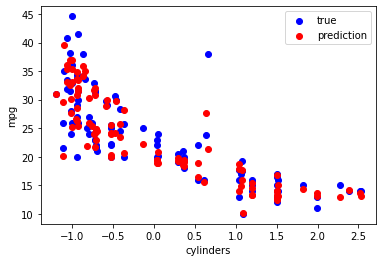

In [17]:
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], y_test, c='b', label="true")
plt.scatter(X_test[:, 0], y_pred, c='r', label="prediction")
plt.xlabel('cylinders')
plt.ylabel('mpg')
plt.legend()